一旦仮で作ったところまで

In [1]:
import pandas as pd

# データAとデータBのCSVファイルのパス
data_a_path = '/Users/whale217/dev/ProjectTeam5/workspace/team1/data/original_data/race_table/combined.csv'  # データAのCSVファイルパス
data_b_path = '/Users/whale217/dev/ProjectTeam5/workspace/team1/data/merged_data/merged_sorted.csv'  # データBのCSVファイルパス

# CSVファイルからデータを読み込む
data_a = pd.read_csv(data_a_path,low_memory=False)
data_b = pd.read_csv(data_b_path)
data_a=data_a.dropna()
data_b=data_b.dropna()
data_a=data_a.drop(columns=['first_horses', 'second_horses', 'third_horses', 'Time', 'Jockey', 'Trainer'])
# Code列でデータを結合 (data_bにdata_aの情報を追加)
merged_data = pd.merge(data_b, data_a, on='Code', how='left')

#結果の確認
merged_data.to_csv('../notebook/data-shin/merged_data_final.csv', index=False)
# 各列のユニークな値とその出現回数を取得
for i in merged_data.columns:
    value_counts = merged_data[i].value_counts()  # 各値とそのカウント
    print(f"{i}: {value_counts}")




KeyboardInterrupt: 

なんかパスが奇妙なエラーを吐くので一旦絶対パス使ってます。

In [1]:
import matplotlib.pyplot as plt
print("matplotlib is successfully installed!")


matplotlib is successfully installed!


In [3]:
import pandas as pd
import numpy as np

# データの読み込み（エンコーディングを指定して文字化け防止）
file_path = '/Users/whale217/dev/ProjectTeam5/workspace/team1/notebook/data-shin/merged_data_final.csv'
df = pd.read_csv(file_path, encoding='utf-8', low_memory=False)

# 1. Sex/Ageを分割して新しい列に追加
df[['Sex', 'Age']] = df['Sex/Age'].str.extract(r'([A-Za-z]+)(\d+)')
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')  # 数値型に変換、変換できないものはNaNに
df.drop(columns=['Sex/Age'], inplace=True)  # 元のSex/Age列を削除

# 2. カテゴリカルデータをOne-Hot Encoding
categorical_columns = ['Sex', 'Jockey', 'Track', 'Weather', 'Condition', 'Trainer', 'Banushi', 'Horse Name']
df = pd.get_dummies(df, columns=categorical_columns, dtype=np.uint8)  # メモリ効率の良い型を指定

# 3. 欠損値の処理（欠損値を削除、文字列データに対してNaNを取り扱う）
df.dropna(subset=['Sex', 'Age'], inplace=True)  # SexやAgeに欠損があれば削除
df.dropna(inplace=True)  # その他の欠損値がある行を削除

# 4. インデックスの異常データを削除（インデックスが重複している行を削除）
df = df.loc[~df.index.duplicated(), :]  # 重複するインデックスを削除

# 5. メモリの最適化（データ型の変更）
# 数値型のカラムに対して適切な型に変換
for col in df.select_dtypes(include=['float64']).columns:
    df[col] = pd.to_numeric(df[col], downcast='float')
for col in df.select_dtypes(include=['int64']).columns:
    df[col] = pd.to_numeric(df[col], downcast='integer')

# 6. 不要な列の削除（CodeやRankなど予測に不要なら削除）
columns_to_drop = ['Code', 'Rank', 'Frame Rank']  # 必要に応じて列を指定
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# 7. 前処理後のデータを新しいCSVファイルに保存
output_path = 'processed_horse_data_optimized.csv'  # 保存するファイル名を指定
df.to_csv(output_path, index=False)

print(f"前処理が完了しました。処理済みデータは {output_path} に保存されました。")


: 

features = [
    "Rank","Kinryou","Nobori","Ninki",
    "Race Number","Distance","Weight","Weight Change",
    "Sex","Age","Ground_ダ","Ground_芝","Ground_障","Condition_不",
    "Condition_稍","Condition_良","Condition_重","Weather_小雨","Weather_小雪",
    "Weather_晴","Weather_曇","Weather_雨","Weather_雪"
]
target = "Time_x"

ランクは相対的であると判断し削除。人気は予想がすでに反映されている可能性がある。。。？
事前にしれるか〜はそれはそう。

In [8]:
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# データの読み込み
file_path = '/Users/whale217/dev/ProjectTeam5/workspace/team1/data/format_data.csv'
df = pd.read_csv(file_path)

# 必要な特徴量とターゲット変数の選択
X = df[[
    "Kinryou", "Nobori","Ninki",
    "Race Number", "Distance", "Weight", "Weight Change",
    "Sex", "Age", "Ground_ダ", "Ground_芝", "Ground_障", 
    "Condition_不", "Condition_稍", "Condition_良", "Condition_重", 
    "Weather_小雨", "Weather_小雪", "Weather_晴", "Weather_曇", "Weather_雨", "Weather_雪"
]]

y = df['Time_x']  # ターゲット変数

# 欠損値を含む行を削除
X = X.dropna()
y = y.loc[X.index]  # Xのインデックスに合わせてyも調整

# データの分割 (訓練データとテストデータ)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.29, random_state=42)

# Lasso回帰モデルの作成と学習
lasso = Lasso(alpha=0.0001)  # alphaは正則化の強さ
lasso.fit(X_train, y_train)

# 予測
y_pred = lasso.predict(X_test)

# 評価 (MSEを表示)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Lassoモデルの係数を表示
print("Lasso coefficients:")
print(lasso.coef_)


/var/folders/0y/s3g9vbzd3vvch0mp2zlmz2pr0000gn/T/ipykernel_4305/3338017571.py:8: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Mean Squared Error: 4.770803048842273
Lasso coefficients:
[ 4.06350365e-02  7.71359869e-01 -3.82349329e-02 -1.29710387e-01
  6.61603465e-02 -7.98144676e-03  1.26426991e-03  2.24191660e-01
  1.67392971e-01  0.00000000e+00 -4.47699293e+00  2.57945542e+01
 -3.85006808e-02  9.56248189e-02 -1.45786027e-01  1.00416077e-01
 -5.98393769e-01  0.00000000e+00  9.80731372e-02 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00]


制度は微妙だが動いてそうだから次に進めます。
以下は学習後に実際に予測させてます。（最初にモデルを作ってます。）

/var/folders/0y/s3g9vbzd3vvch0mp2zlmz2pr0000gn/T/ipykernel_13451/379298794.py:10: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
findfont: Font family 'MS Gothic' not found.
findfont: Font family 'MS Gothic' not found.
/Users/whale217/.pyenv/versions/3.10.4/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20108 (\N{CJK UNIFIED IDEOGRAPH-4E8C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/whale217/.pyenv/versions/3.10.4/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20055 (\N{CJK UNIFIED IDEOGRAPH-4E57}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/whale217/.pyenv/versions/3.10.4/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20516 (\N{CJK UNIFIED IDEOGRAPH-5024}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, *

Mean Squared Error: 4.84028093080422
Mean Squared Error: 4.830646384680077
Lasso coefficients:
[ 4.01526040e-02  7.78924808e-01 -3.87878313e-02 -1.28646536e-01
  6.61232466e-02 -8.01867388e-03  1.28359552e-03  2.22936321e-01
  1.67336993e-01  2.10786155e+00 -2.33572449e+00  2.82254795e+01
 -1.23811478e-02  1.33416380e-01 -1.19059157e-01  1.30935848e-01
 -6.69448807e-01  4.90640717e-02  8.51935459e-02 -8.98580574e-03
 -1.56956990e-02  7.00298104e-02]


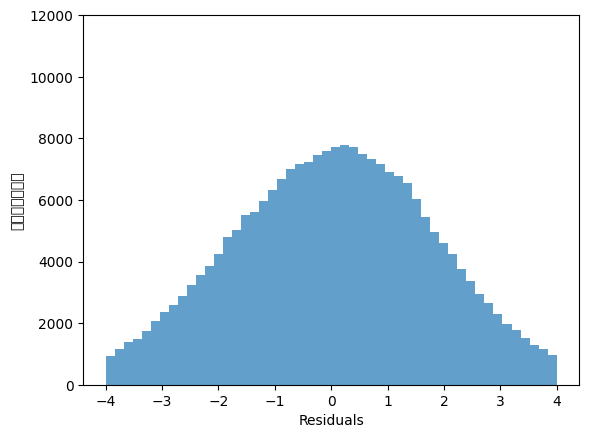

In [ ]:
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import joblib
import matplotlib.pyplot as plt

# データの読み込み
file_path = '/Users/whale217/dev/ProjectTeam5/workspace/team1/data/format_data.csv'
df = pd.read_csv(file_path)

# Rankを除外して特徴量とターゲット変数を選択
X = df[[
    "Kinryou", "Nobori","Ninki", "Race Number", "Distance", "Weight", "Weight Change",
    "Sex", "Age", "Ground_ダ", "Ground_芝", "Ground_障", 
    "Condition_不", "Condition_稍", "Condition_良", "Condition_重", 
    "Weather_小雨", "Weather_小雪", "Weather_晴", "Weather_曇", "Weather_雨", "Weather_雪"
]]

y = df['Time_x']  # ターゲット変数

# 欠損値を含む行を削除
X = X.dropna()
y = y.loc[X.index]  # Xのインデックスに合わせてyも調整

# データの分割 (訓練データとテストデータ)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Lasso回帰モデルの作成と学習
lasso = Lasso(alpha=0.0001)  # alphaは正則化の強さ
lasso.fit(X_train, y_train)

# 予測
y_pred = lasso.predict(X_train)

mse = mean_squared_error(y_train, y_pred)
print(f'Mean Squared Error: {mse}')

# 予測
y_pred = lasso.predict(X_test)

# 評価 (MSEを表示)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Lassoモデルの係数を表示
print("Lasso coefficients:")
print(lasso.coef_)

#モデルの保持
model_filename = 'lasso_model.pkl'
joblib.dump(lasso, model_filename)

time_diff = y_test - y_pred

plt.ylim(0,12000)
plt.hist(time_diff, bins=50, alpha=0.7,  range=(-4, 4))  # 修正: 横軸の範囲を-2から2に設定
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


In [3]:
import joblib


# モデルの読み込み
loaded_model = joblib.load('lasso_model.pkl')

# 新しいデータに対して予測を行う
new_data = pd.DataFrame({
    "Kinryou": [55.0],
    "Nobori": [35.2],
    "Ninki": [3],
    "Race Number": [5],
    "Distance": [1800],
    "Weight": [470],
    "Weight Change": [2],
    "Sex": [1],
    "Age": [4],
    "Ground_ダ": [1],
    "Ground_芝": [0],
    "Ground_障": [0],
    "Condition_不": [0], "Condition_稍": [1], "Condition_良": [0], "Condition_重": [0],
    "Weather_小雨": [0], "Weather_小雪": [0], "Weather_晴": [1], "Weather_曇": [0],
    "Weather_雨": [0], "Weather_雪": [0]
})

# モデルで新しいデータを予測
predicted_time = loaded_model.predict(new_data)

# 予測結果を表示
print(f"予測されたTime_x: {predicted_time[0]}")


予測されたTime_x: 114.21266431834896


testデータと学習用データの比率に最適化がしたい。（過学習を防ぎたい）
alpha値も最適な値定めるべきよね。

得られた情報
最小のMSE: 4.7825
最適なalpha: 0.0001
最適なtest_size: 0.29

/var/folders/0y/s3g9vbzd3vvch0mp2zlmz2pr0000gn/T/ipykernel_16943/284990196.py:13: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


最小のMSE: 4.7825
最適なalpha: 0.0001
最適なtest_size: 0.2895


/Users/whale217/.pyenv/versions/3.10.4/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22793 (\N{CJK UNIFIED IDEOGRAPH-5909}) missing from font(s) AppleMyungjo.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/whale217/.pyenv/versions/3.10.4/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24375 (\N{CJK UNIFIED IDEOGRAPH-5F37}) missing from font(s) AppleMyungjo.
  fig.canvas.print_figure(bytes_io, **kw)


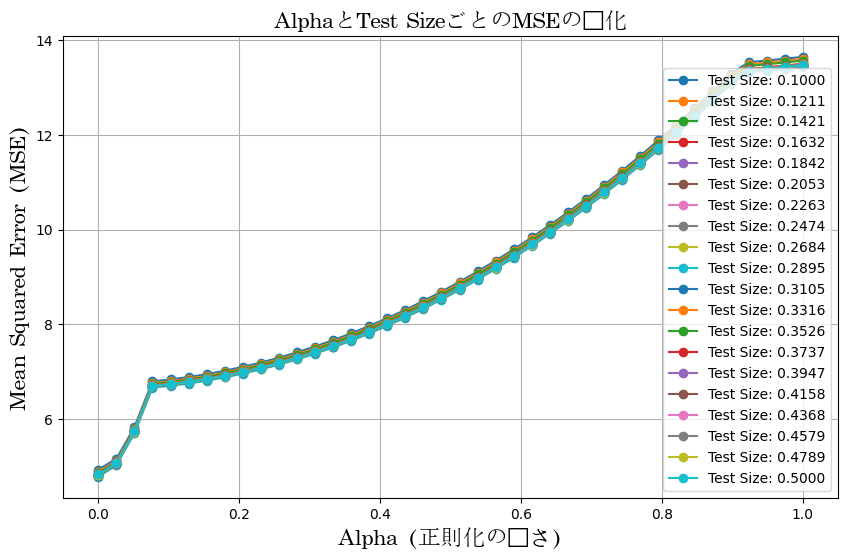

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from matplotlib.font_manager import FontProperties

fp = FontProperties(fname=r'/System/Library/Fonts/Supplemental/AppleMyungjo.ttf', size=16)

# データの読み込み
file_path = '/Users/whale217/dev/ProjectTeam5/workspace/team1/data/format_data.csv'
df = pd.read_csv(file_path)

# 必要な特徴量とターゲット変数の選択
X = df[[
    "Kinryou", "Nobori", "Race Number", "Distance", "Weight", "Weight Change",
    "Sex", "Age", "Ground_ダ", "Ground_芝", "Ground_障", 
    "Condition_不", "Condition_稍", "Condition_良", "Condition_重", 
    "Weather_小雨", "Weather_小雪", "Weather_晴", "Weather_曇", "Weather_雨", "Weather_雪"
]]
y = df['Time_x']

# 欠損値を含む行を削除
X = X.dropna()
y = y.loc[X.index]

# alphaとtest_sizeの設定範囲
alphas = np.linspace(0.0001, 1.0, 40)  # alpha: 0.0001 から 1.0 まで40分割
test_sizes = np.linspace(0.1, 0.5, 20)  # test_size: 0.1 から 0.5 まで20分割

# MSEの結果を記録するリスト
results = []

# alphaとtest_sizeの組み合わせでMSEを計算
for alpha in alphas:
    for test_size in test_sizes:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        lasso = Lasso(alpha=alpha)
        lasso.fit(X_train, y_train)
        y_pred = lasso.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        results.append((alpha, test_size, mse))

# 結果をDataFrameにまとめる
results_df = pd.DataFrame(results, columns=['Alpha', 'Test_Size', 'MSE'])

# 最小MSEの行を取得
best_result = results_df.loc[results_df['MSE'].idxmin()]

# 最適なalphaとtest_sizeの表示
print(f"最小のMSE: {best_result['MSE']:.4f}")
print(f"最適なalpha: {best_result['Alpha']:.4f}")
print(f"最適なtest_size: {best_result['Test_Size']:.4f}")

# グラフの描画: alphaごとのMSEの変化 (複数のtest_size)
plt.figure(figsize=(10, 6))
for test_size in test_sizes:
    subset = results_df[results_df['Test_Size'] == test_size]
    plt.plot(subset['Alpha'], subset['MSE'], marker='o', label=f'Test Size: {test_size:.4f}')

plt.xlabel('Alpha (正則化の強さ)',fontproperties=fp)
plt.ylabel('Mean Squared Error (MSE)', fontproperties=fp)
plt.title('AlphaとTest SizeごとのMSEの変化', fontproperties=fp)
plt.legend()
plt.grid(True)
plt.show()


フォントが絶妙にバグってる。。。
直接書き込むでスライドは対応してます。

In [4]:
import matplotlib.font_manager as fm

# 利用可能なフォント一覧を表示
for font in fm.fontManager.ttflist:
    if 'JP' in font.name or 'Noto' in font.name or 'Osaka' in font.name:
        print(font.name, font.fname)


Noto Sans Bamum /System/Library/Fonts/Supplemental/NotoSansBamum-Regular.ttf
Noto Sans Rejang /System/Library/Fonts/Supplemental/NotoSansRejang-Regular.ttf
Noto Sans Old Turkic /System/Library/Fonts/Supplemental/NotoSansOldTurkic-Regular.ttf
Noto Sans Tai Viet /System/Library/Fonts/Supplemental/NotoSansTaiViet-Regular.ttf
Noto Sans Sora Sompeng /System/Library/Fonts/Supplemental/NotoSansSoraSompeng-Regular.ttf
Noto Sans Tirhuta /System/Library/Fonts/Supplemental/NotoSansTirhuta-Regular.ttf
Noto Sans Osage /System/Library/Fonts/Supplemental/NotoSansOsage-Regular.ttf
Noto Sans NKo /System/Library/Fonts/Supplemental/NotoSansNKo-Regular.ttf
Noto Sans Ugaritic /System/Library/Fonts/Supplemental/NotoSansUgaritic-Regular.ttf
Noto Sans Marchen /System/Library/Fonts/Supplemental/NotoSansMarchen-Regular.ttf
Noto Sans Cham /System/Library/Fonts/Supplemental/NotoSansCham-Regular.ttf
Noto Sans Thaana /System/Library/Fonts/Supplemental/NotoSansThaana-Regular.ttf
Noto Nastaliq Urdu /System/Library/Fo